In [8]:
import cell2location
import scanpy as sc
import numpy as np

#assinaturas
adata_ref_with_signatures_path = '../../data/output/adata_ref_with_signatures.h5ad'
adata_ref_with_signatures = sc.read_h5ad(adata_ref_with_signatures_path)

In [3]:
inf_aver = adata_ref_with_signatures.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' \
                                           for i in adata_ref_with_signatures.uns['mod']['factor_names']]]
inf_aver.columns = adata_ref_with_signatures.uns['mod']['factor_names']

In [5]:
#prepare visium data

normal_sample_url = 'https://datasets.cellxgene.cziscience.com/3574c8a3-2bf8-4aa6-97b8-3c4a7751757a.h5ad'
cancer_sample_url = 'https://datasets.cellxgene.cziscience.com/6cffa6f2-fd1b-49ab-841e-5fcbeab669df.h5ad'

normal_sample = sc.read(
    f'./data/normal_sample_spatial.h5ad',
    backup_url=normal_sample_url
)

cancer_sample = sc.read(
    f'./data/cancer_sample_spatial.h5ad',
    backup_url=cancer_sample_url
)

In [7]:
cancer_sample.obs['sample'] = list(cancer_sample.uns['spatial'].keys())[0]
cancer_sample.var['SYMBOL'] = cancer_sample.var['feature_name']

# find mitochondria-encoded (MT) genes
cancer_sample.var['MT_gene'] = [gene.startswith('MT-') for gene in cancer_sample.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
cancer_sample.obsm['MT'] = cancer_sample[:, cancer_sample.var['MT_gene'].values].X.toarray()
cancer_sample = cancer_sample[:, ~cancer_sample.var['MT_gene'].values]


In [9]:
intersect = np.intersect1d(cancer_sample.var_names, inf_aver.index)

cancer_sample = cancer_sample[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=cancer_sample, batch_key="sample")

In [19]:
cell2location_hyperparameters = {
    'N_cells_per_location': 30,
    'detection_alpha': 20, # or 200
    'max_epochs': 100
}

In [20]:
map_model = cell2location.models.Cell2location(
    cancer_sample, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=cell2location_hyperparameters['N_cells_per_location'],
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=cell2location_hyperparameters['detection_alpha']
)
map_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4992  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11522 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ GSM6592049_M2 │          0          │
└─────────────────────┴───────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [21]:
map_model.train(max_epochs=cell2location_hyperparameters['max_epochs'],
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
)

[03/12/25 21:35:36] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=892060;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=969377;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/scvi/dataloaders/_da                
                             ta_splitting.py:629: UserWarning: `accelerator` has been automatically                
                             set to `cpu` although 'mps' exists. If you wish to run on mps backend,                
                             use explicitly accelerator=='mps' in train function.In future releases                
                             it will become default for mps supported machines.                                    
                               _, _, self.device = parse_device_args(                                              
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=700744;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=20297;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/scvi/train/_trainrun                
                             ner.py:69: UserWarning: `accelerator` has been automatically set to                   
                             `cpu` although 'mps' exists. If you wish to run on mps backend, use                   
                             explicitly accelerator=='mps' in train function.In future releases it                 
                             will become default for mps supported machines.                                       
                               accelerator, lightning_devices, device = parse_device_args(                         
                                                                                                                   

INFO: GPU available: True (mps), used: False


                    INFO     GPU available: True (mps), used: False                                 ]8;id=567635;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=21145;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=498760;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=856896;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=814594;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=2650;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=29388;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=803998;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/setup.py:177: GPU available but not used. You can set it by                     
                             doing `Trainer(accelerator='gpu')`.                                                   
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=127166;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=380540;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/configuration_validator.py:68: You passed in a `val_dataloader`                 
                             but have no `validation_step`. Skipping val loop.                                     
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=711844;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=18596;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/tr                
                             ainer/connectors/data_connector.py:425: The 'train_dataloader' does                   
                             not have many workers which may be a bottleneck. Consider increasing                  
                             the value of the `num_workers` argument` to `num_workers=10` in the                   
                             `DataLoader` to improve performance.                                                  
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=960156;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=709625;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning/pytorch/lo                
                             ops/fit_loop.py:310: The number of training batches (1) is smaller                    
                             than the logging interval Trainer(log_every_n_steps=10). Set a lower                  
                             value for log_every_n_steps if you want to see logs for the training                  
                             epoch.                                                                                
                                                                                                                   

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


[03/12/25 21:38:11] INFO     `Trainer.fit` stopped: `max_epochs=100` reached.                       ]8;id=739946;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=805907;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot ELBO loss history during training, removing first 100 epochs from the plot
map_model.plot_history(10)
plt.legend(labels=['full data training']);

In [35]:
cancer_sample = map_model.export_posterior(
    cancer_sample, sample_kwargs={'num_samples': 1, 'batch_size': map_model.adata.n_obs}
)

Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample: : 0it [00:00, ?it/s]

In [36]:
# # Save model
# mod.save(f"{run_name}", overwrite=True)

# # mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# # Save anndata object with results
# adata_file = f"{run_name}/sp.h5ad"
# adata_vis.write(adata_file)
# adata_file

# adata_file = f"{run_name}/sp.h5ad"
# adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [37]:
map_model.plot_QC()

[03/12/25 21:52:27] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=516127;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=508514;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/cell2location/models                
                             /_cell2location_model.py:435: FutureWarning: Use                                      
                             `squidpy.pl.spatial_scatter` instead.                                                 
                               scanpy.pl.spatial(                                                                  
                                                                                                                   

[03/12/25 21:52:28] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=605223;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=203707;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/cell2location/models                
                             /_cell2location_model.py:456: FutureWarning: Use                                      
                             `squidpy.pl.spatial_scatter` instead.                                                 
                               scanpy.pl.spatial(                                                                  
                                                                                                                   

                    WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=373365;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=709589;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/cell2location/models                
                             /_cell2location_model.py:477: FutureWarning: Use                                      
                             `squidpy.pl.spatial_scatter` instead.                                                 
                               scanpy.pl.spatial(                                                                  
                                                                                                                   

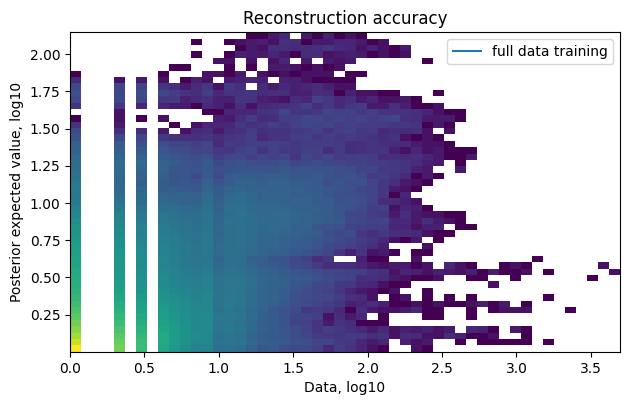

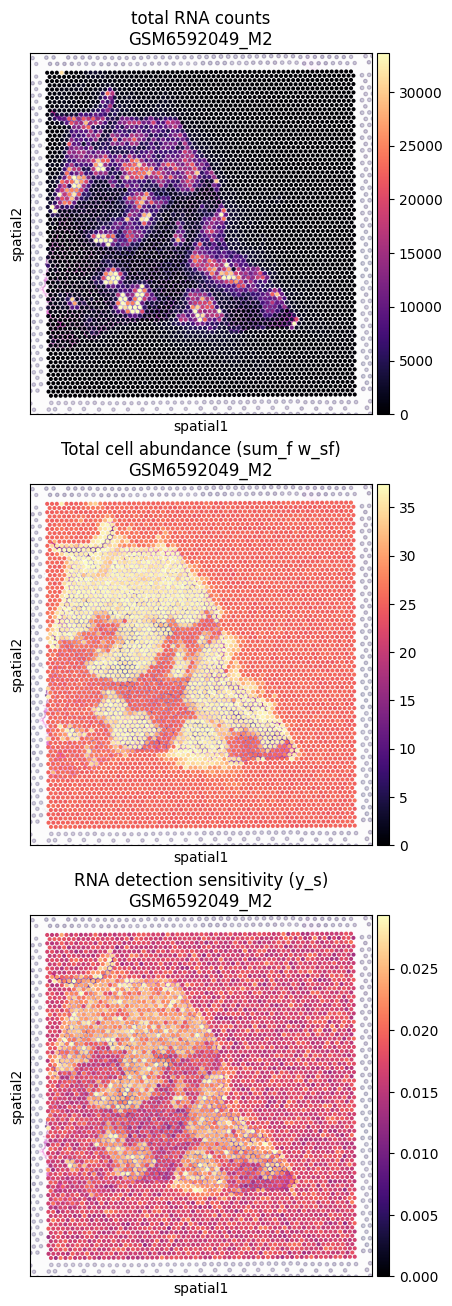

In [38]:
fig = map_model.plot_spatial_QC_across_batches()

In [39]:
# Compute expected expression per cell type
expected_dict = map_model.module.model.compute_expected_per_cell_type(
    map_model.samples["post_sample_q05"], map_model.adata_manager
)

# Add to anndata layers
for i, n in enumerate(map_model.factor_names_):
    cancer_sample.layers[n] = expected_dict['mu'][i]

In [41]:
import matplotlib as mpl
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    # slide = select_slide(, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(cancer_sample, genes, ctypes);

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   # select one slide                                                                      │
│    8 │   # slide = select_slide(, 'V1_Human_Lymph_Node')                                         │
│    9 │                                                                                           │
│ ❱ 10 │   from tutorial_utils import plot_genes_per_cell_type                                     │
│   11 │   plot_genes_per_cell_type(cancer_sample, genes, ctypes);                                 │
│   12                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'tutorial_utils'